In [1]:
import os, json, time, joblib
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    f1_score, accuracy_score, brier_score_loss, confusion_matrix, classification_report
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# ---------- Funcion para imprimir resultados por pantalla ------------ 
def print_metrics(y_true, y_pred, y_proba=None, title=None):
    if title: print(f"\n=== {title} ===")
    acc = accuracy_score(y_true, y_pred)
    print(f"\n🎯 Accuracy: {acc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    if y_proba is not None:
        print("\nProb-metrics:")
        print(f"ROC-AUC : {roc_auc_score(y_true, y_proba):.4f}")
        print(f"PR-AUC  : {average_precision_score(y_true, y_proba):.4f}")
        print(f"Brier   : {brier_score_loss(y_true, y_proba):.4f}")

#### ======================================= ####
#### RANDOM FOREST: TRAIN + CALIBRATE + SAVE ####
#### ======================================= ####

In [ ]:
%%time

# ---------- Paths
DATA_PATH = "../datasets/final/ico_dataset_final_v2_clean_enriquecido_feature_engineering_preico_v1.csv"
STAMP = time.strftime("%Y%m%d_%H%M%S")
EXP_DIR = f"experiments/random_forest_v1"
FIG_DIR = os.path.join(EXP_DIR, "figs")
os.makedirs(FIG_DIR, exist_ok=True)

# ---------- Load Dataset
df = pd.read_csv(DATA_PATH)
target = "ico_successful"
df[target] = df[target].astype(int)
df = df.dropna(subset=[target])
print(f"Dataset cargado → {df.shape[0]} filas, {df.shape[1]} columnas")

# ---------- Feature blocks (mismos que tus baselines)
cat_candidates = ["platform", "category", "location"]
bin_candidates = [
    "mvp","has_twitter","has_facebook","is_tax_regulated","has_github",
    "has_reddit","has_website","has_whitepaper","kyc",
    "accepts_BTC","accepts_ETH","has_contract_address"
]
cat_cols = [c for c in cat_candidates if c in df.columns]
bin_cols = [c for c in bin_candidates if c in df.columns]
num_cols = [c for c in df.columns if c not in cat_cols + bin_cols + [target]]

# ---------- Preprocess
# (RF no necesita escalado, pero mantenemos el pipeline homogéneo y seguro con imputaciones)
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first"))])
bin_pipe = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value=0))])

pre = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols), ("bin", bin_pipe, bin_cols)],
                        remainder="drop", sparse_threshold=0.3)


# ---------- Split
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
print(f"Variables finales: {X.shape[1]}  |  Filas usadas: {X.shape[0]}")


# ---------- Modelo
rf = RandomForestClassifier(
    n_estimators=500,          # base sólido
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf_pipe = Pipeline([("pre", pre), ("clf", rf)])

# ---------- Grid 
rf_grid = {
    "clf__n_estimators": [300, 500, 700],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [2, 4, 8],
    "clf__max_features": ["sqrt", "log2"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(rf_pipe, rf_grid, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True)
gs.fit(X_train, y_train)

best_rf = gs.best_estimator_
y_proba = best_rf.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

m_rf = {
    "model": "random_forest",
    "best_params": gs.best_params_,
    "roc_auc": float(roc_auc_score(y_test, y_proba)),
    "pr_auc": float(average_precision_score(y_test, y_proba)),
    "f1": float(f1_score(y_test, y_pred)),
    "accuracy": float(accuracy_score(y_test, y_pred)),
    "brier": float(brier_score_loss(y_test, y_proba)),
    "confusion_matrix": confusion_matrix(y_test, y_pred).tolist(),
}


# ------------------ EVALUACIÓNain con calibracion ------------------ #
print("RF metrics:", m_rf)
print_metrics(y_test, y_pred, y_proba, title="Random Forest")


# ---------- Calibración (Isotónica)
cal = CalibratedClassifierCV(estimator=best_rf.named_steps["clf"], method="isotonic", cv=5)
rf_cal_pipe = Pipeline([("pre", pre), ("cal", cal)])
rf_cal_pipe.fit(X_train, y_train)

y_proba_cal = rf_cal_pipe.predict_proba(X_test)[:, 1]
y_pred_cal  = (y_proba_cal >= 0.5).astype(int)
m_rf_cal = {
    "model": "rf_calibrated_isotonic",
    #"best_params": rf_cal_pipe.best_params_,
    "roc_auc": float(roc_auc_score(y_test, y_proba_cal)),
    "pr_auc": float(average_precision_score(y_test, y_proba_cal)),
    "f1": float(f1_score(y_test, y_pred_cal)),
    "accuracy": float(accuracy_score(y_test, y_pred_cal)),
    "brier": float(brier_score_loss(y_test, y_proba_cal)),
    "confusion_matrix": confusion_matrix(y_test, y_pred_cal).tolist(),
}


# ------------------ EVALUACIÓN con calibracion ------------------ #
print("RF calibrated metrics:", m_rf_cal)
print_metrics(y_test, y_pred_cal, y_proba_cal, title="Random Forest (calibrated)")


# ---------- Gráficos (1 fig por plot, sin estilos ni colores fijos)
print("\nGráficos:")
# ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba)
fpr_cal, tpr_cal, _ = roc_curve(y_test, y_proba_cal)
plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={m_rf['roc_auc']:.3f})")
plt.plot(fpr_cal, tpr_cal, label=f"RF + Cal (AUC={m_rf_cal['roc_auc']:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves"); plt.legend()
plt.show()
plt.savefig(os.path.join(FIG_DIR, "roc_rf.png"), bbox_inches="tight"); plt.close()

# PR
p_rf, r_rf, _ = precision_recall_curve(y_test, y_proba)
p_c,  r_c,  _ = precision_recall_curve(y_test, y_proba_cal)
plt.figure()
plt.plot(r_rf, p_rf, label=f"RF (AP={m_rf['pr_auc']:.3f})")
plt.plot(r_c,  p_c,  label=f"RF + Cal (AP={m_rf_cal['pr_auc']:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curves"); plt.legend()
plt.show()
plt.savefig(os.path.join(FIG_DIR, "pr_rf.png"), bbox_inches="tight"); plt.close()

# Calibración
prob_true, prob_pred = calibration_curve(y_test, y_proba_cal, n_bins=10, strategy="uniform")
plt.figure()
plt.plot(prob_pred, prob_true, marker="o", linewidth=1, label="RF Calibrated")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Calibration Curve (RF Isotonic)"); plt.legend()
plt.show()
plt.savefig(os.path.join(FIG_DIR, "calibration_rf.png"), bbox_inches="tight"); plt.close()


# ---------- Guardar artefactos
os.makedirs(EXP_DIR, exist_ok=True)
pd.DataFrame({
    "y_true": y_test.values,
    "proba_rf": y_proba,
    "proba_rf_cal": y_proba_cal
}).to_csv(os.path.join(EXP_DIR, "test_predictions.csv"), index=False)

with open(os.path.join(EXP_DIR, "metrics.json"), "w") as f:
    json.dump({"rf": m_rf, "rf_calibrated": m_rf_cal}, f, indent=2)

joblib.dump(best_rf,     os.path.join(EXP_DIR, "best_rf.pkl"))
joblib.dump(rf_cal_pipe, os.path.join(EXP_DIR, "rf_isotonic_calibrated.pkl"))

print("\nArtefactos guardados en:", EXP_DIR)


Dataset cargado → 3827 filas, 17 columnas
Variables finales: 16  |  Filas usadas: 3827


In [4]:

import matplotlib.pyplot as plt
print("\nBest params LR:", gs.best_params_)

importances = pd.Series(gs.best_estimator_._final_estimator.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 15 features más relevantes:")
print(importances.head(15).to_string())
plt.figure(figsize=(10,5))
importances.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (RandomForest)")
plt.show()


Best params LR: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}


ValueError: Length of values (67) does not match length of index (32)

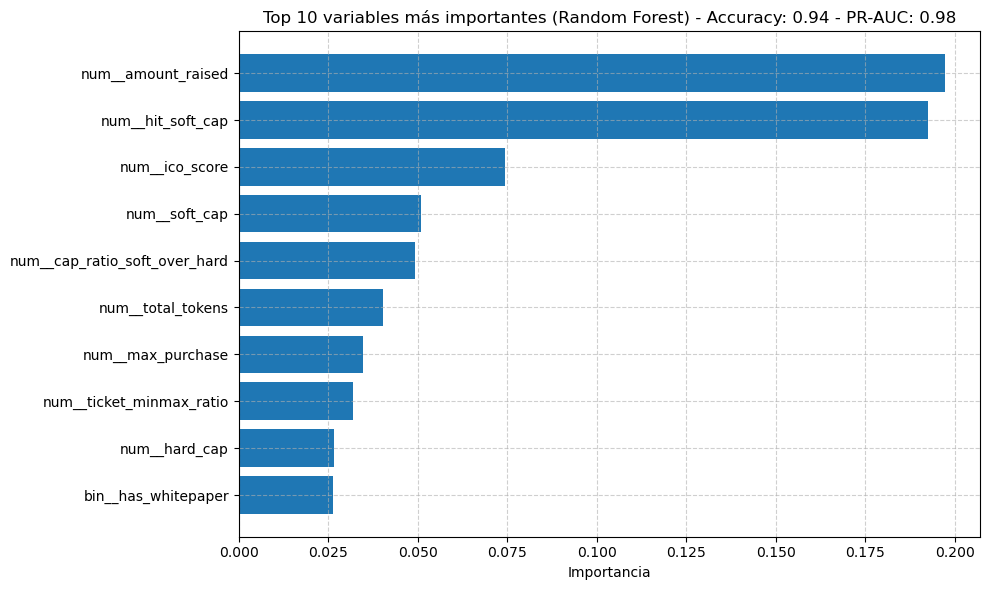

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer nombres de features del preprocesador (si usás un ColumnTransformer)
feature_names = best_rf.named_steps["pre"].get_feature_names_out()

# Extraer importancias del clasificador
importances = best_rf.named_steps["clf"].feature_importances_
indices = np.argsort(importances)[-10:][::-1]  # Top 15 más importantes

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(range(10), importances[indices], align="center")
plt.yticks(range(10), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.title(f"Top 10 variables más importantes (Random Forest) - Accuracy: {m_rf['accuracy']:.2f} - PR-AUC: {m_rf['pr_auc']:.2f}")
plt.xlabel("Importancia")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


NameError: name 'gs_rf' is not defined